In [1]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
from bundle_adjust import ba_utils               
from bundle_adjust import rpc_fit
from IS18 import vistools               # display tools
from IS18 import utils                  # IO tools
from IS18 import rectification          # rectification tools
from IS18 import stereo                 # stereo tools
from IS18 import triangulation          # triangulation tools

import s2p
import pickle
import rpcm
import glob
import json
import copy
import timeit
import srtm4

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Experiment name 

In [3]:
exp_name = 'skysat_coal_singledate' #'skysat_L1A_dona_juana2' #
input_dir = os.path.join('exp/',exp_name)
src_dir = os.path.join('data/',exp_name)

if not os.path.exists(src_dir):
    print('ERROR: source path does not exist!')
else:
    os.makedirs(input_dir, exist_ok=True)

### Read SkySat images and RPCs

In [4]:
# read tiff images 
myimages = np.sort(glob.glob(src_dir+'/*.tif'))
#myimages = myimages[:3]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
myimg = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    myimg.append(utils.simple_equalization_8bit(tmp))
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'col0': 0.0, 'row0': 0.0 })

# load RPC coefficients
myrpcs = [rpcm.rpc_from_rpc_file(os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
#myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# update myimages list
pickle_out = open(input_dir+'/myimages.pickle','wb')
pickle.dump([os.path.basename(imagefn) for imagefn in myimages], pickle_out)
pickle_out.close()

Found 9 images
Number of images to be used: 9
Finished loading RPC coefficients


### RPCs from projection matrices

In [5]:
#if not os.path.isdir(input_dir+'/rpc_from_P'):
#    os.mkdir(input_dir+'/rpc_from_P')

# rpc fitting starts here
verbose = True
for im_idx in range(len(myrpcs)):

    rpc_init = copy.copy(myrpcs[im_idx])
    h, w = mycrops[im_idx]['crop'].shape
    
    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
        input_P = np.array(json.load(f)['P_projective'])
    
    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 500, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    # warning: this is slow...
    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts, samples = p[idx_to_preserve], samples[idx_to_preserve]

    #fig = plt.figure(figsize=(20,6))
    #plt.imshow((mycrops[im_idx]['crop']), cmap="gray")
    #for k in range(proj_pts.shape[0]):
    #    plt.plot(*proj_pts[k][::-1], 'rx') 
    #plt.show()
    
    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    #rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    #rpc_calib.write_to_file(input_dir+'/rpc_from_P/'+rpc_calib_fn)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

    myrpcs[im_idx] = copy.copy(rpc_calib)

FileNotFoundError: [Errno 2] No such file or directory: 'data/skysat_coal_singledate/20190617_075138_ssc2d2_0005_basic_panchromatic_dn_pinhole.json'

### Read projection matrices

In [ ]:
cam_model = 'Perspective'
P_crop = []
for iter_cont in np.arange(len(mycrops)):
    with open(os.path.splitext(myimages[iter_cont])[0]+'_pinhole.json', 'r') as f:
        P_img = np.array(json.load(f)['P_projective'])
    P_crop.append(P_img/P_img[2,3])
    print('\rCamera {} / {} done'.format(iter_cont+1, len(mycrops)), end = '\r')
print('\nProjection matrices read')

### Set bundle adjustment input and load pipeline

ba_input_data set!
ret 1057.134697475096
intrinsic parameters: [[2.53778848e+05 0.00000000e+00 1.64593398e+03]
 [0.00000000e+00 2.53778848e+05 6.48001366e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[-1.0064885 ],
       [ 0.50577738],
       [ 0.97758741]])],
T:[array([[-1.01881578e+04],
       [ 3.18978041e+04],
       [ 1.10442234e+07]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


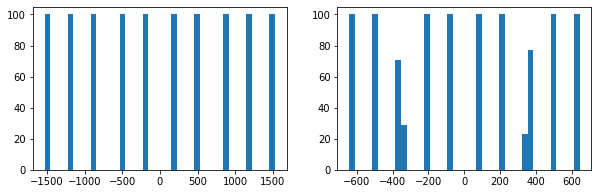

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1530.3773990711572 1530.4439022494043 0.0005575638146974597
distance on rows: -644.5609005193195 644.3126711421253 -0.0015870791110046412
ret 1053.3200925439694
intrinsic parameters: [[2.73202340e+05 0.00000000e+00 1.64793599e+03]
 [0.00000000e+00 2.73202341e+05 6.46291166e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[-1.00656681],
       [ 0.50613698],
       [ 0.97684593]])],
T:[array([[  -11083.28394391],
       [   34745.49405716],
       [11044514.89907285]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


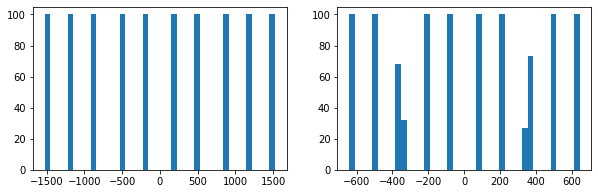

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1525.1559959479116 1525.2276674611908 0.0012306065559178022
distance on rows: -642.2880604932383 642.0338973957475 -0.0017539656309945712
ret 1047.3650696385257
intrinsic parameters: [[3.03393985e+05 0.00000000e+00 1.64819019e+03]
 [0.00000000e+00 3.03393985e+05 6.46581237e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[-1.00619315],
       [ 0.506384  ],
       [ 0.97624201]])],
T:[array([[  -11056.84245331],
       [   34795.27563748],
       [11044829.52892471]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


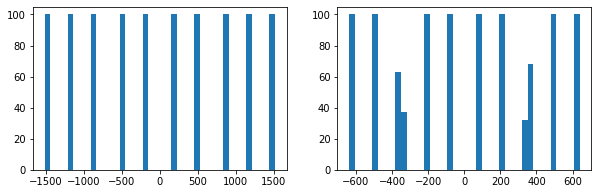

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1517.0157478462618 1517.092664688251 0.0008683978163035135
distance on rows: -638.7563577413871 638.4955983452257 -0.0016955598668755556
ret 1403.9737573897837
intrinsic parameters: [[1.60901565e+06 0.00000000e+00 1.59950000e+03]
 [0.00000000e+00 1.60901565e+06 6.74500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.66400375],
       [ 1.11732851],
       [-1.95071002]])],
T:[array([[   35247.76674043],
       [  -14799.52996659],
       [10739869.7090708 ]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


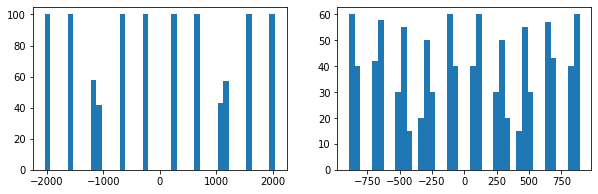

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -2042.4807024922907 2043.6315555977405 0.4486613010664132
distance on rows: -891.9592116415389 891.3424463895287 -0.269144713022597
ret 1428.9469296925427
intrinsic parameters: [[1.70723028e+06 0.00000000e+00 1.59950000e+03]
 [0.00000000e+00 1.70723028e+06 6.74500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.66570166],
       [ 1.11698685],
       [-1.95459639]])],
T:[array([[   40535.82771833],
       [  -13689.48792026],
       [10644082.45624893]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


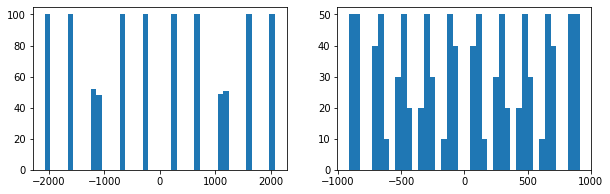

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -2080.510491727952 2081.723853562621 0.46832301524294506
distance on rows: -911.8877868407312 911.2972538783524 -0.25358927644168217
ret 1432.519457893514
intrinsic parameters: [[1.51260008e+06 0.00000000e+00 1.59950000e+03]
 [0.00000000e+00 1.51260008e+06 6.74500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.66863022],
       [ 1.11912846],
       [-1.96609473]])],
T:[array([[   72393.37228377],
       [  -18199.80089931],
       [10112408.47943952]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


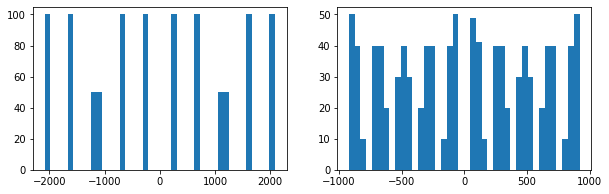

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -2087.54855971128 2088.9556184308963 0.5640923530756626
distance on rows: -919.4176647192196 918.648117409683 -0.34415383984236175
ret 1296.5374990231817
intrinsic parameters: [[8.82468300e+05 0.00000000e+00 1.95182091e+03]
 [0.00000000e+00 8.82467921e+05 1.33378232e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.59097791],
       [ 1.0066747 ],
       [-1.93367293]])],
T:[array([[ -118346.66697788],
       [  621144.15263848],
       [10685342.05239456]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


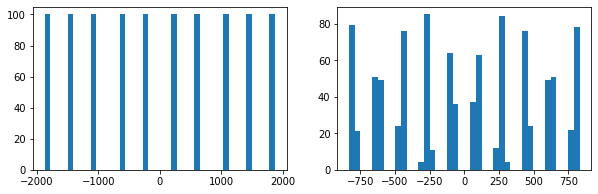

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1870.6735399438728 1871.967589822676 0.5712814514839992
distance on rows: -830.1245097840708 829.9062378960964 -0.23467783663897354
ret 1287.9227611999584
intrinsic parameters: [[8.72134870e+05 0.00000000e+00 1.73727938e+03]
 [0.00000000e+00 8.72134848e+05 8.66689476e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.61656651],
       [ 1.04731636],
       [-1.93421856]])],
T:[array([[  -73405.74678612],
       [  384273.99224761],
       [10873050.38622173]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


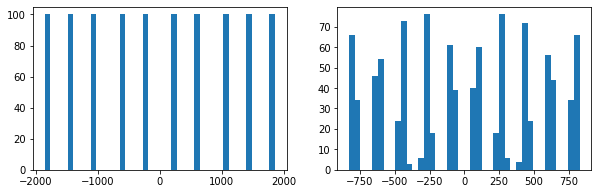

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1859.331812097623 1861.3948721450824 0.9575217332609681
distance on rows: -829.1754116323553 828.4906109694037 -0.4702642877380131
ret 1288.425296822174
intrinsic parameters: [[8.71338838e+05 0.00000000e+00 1.73825060e+03]
 [0.00000000e+00 8.71338819e+05 8.62400900e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsic parameters: 
R:[array([[ 0.60737022],
       [ 1.05012245],
       [-1.92255785]])],
T:[array([[  -72829.3965847 ],
       [  380813.22933518],
       [10877215.82877568]])]
distortion parameters: [[0. 0. 0. 0. 0.]]


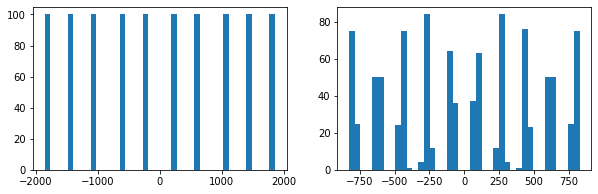

approximate_rpc_as_projective: (min, max, mean)
distance on cols: -1858.731904834635 1860.275089562258 0.6961022118401207
distance on rows: -826.6363898277865 826.227683397845 -0.33116380549337193


In [17]:
ba_input_data = {}
ba_input_data['input_dir'] = input_dir
ba_input_data['output_dir'] = input_dir
ba_input_data['n_adj'] = 0
ba_input_data['n_new'] = len(myimages)
ba_input_data['image_fnames'] = myimages
ba_input_data['crops'] = mycrops
ba_input_data['rpcs'] = myrpcs
ba_input_data['cam_model'] = 'Perspective'
ba_input_data['masks'] = None
ba_input_data['aoi'] = None

print('ba_input_data set!')



config = {'s2p': False,
           'matching_thr': 0.8,
           'use_masks': False,
           'filter_pairs': True,
           'max_kp': 9000,
           'optimal_subset': False,
           'K': 30,
           'tie_points': False,
           'continue': False}
            

from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline

ba_pipeline = BundleAdjustmentPipeline(ba_input_data, tracks_config=config)
#ba_pipeline.display_aoi()

In [79]:
import cv2

K, R, t, _, _, _, _ = cv2.decomposeProjectionMatrix(ba_pipeline.input_P[0])

print(K, R, t)

[[ 4.98476812e-02  1.93359614e-02 -1.11499704e-02]
 [ 0.00000000e+00  2.77093140e-02  4.72598139e-02]
 [ 0.00000000e+00  0.00000000e+00  1.79138278e-07]] [[ 0.25431514 -0.96021074 -0.070453  ]
 [ 0.85966492  0.19367484  0.46374921]
 [-0.43528707 -0.17850442  0.87471394]] [[-7.53070596e-01]
 [-4.83173375e-01]
 [ 4.46573809e-01]
 [-1.45863002e-07]]


In [38]:
ba_pipeline.save_initial_matrices()


Bundle adjusted projection matrices successfully saved!



In [18]:
ba_pipeline.save_crops(input_dir)


Image crops were saved at exp/skysat_coal_singledate/images



### Run bundle adjustment

In [22]:
# compute feature tracks
ba_pipeline.compute_feature_tracks()

Building feature tracks - satellite scenario - using opencv SIFT

Parameters:
      use_masks:    False
      matching_thr: 0.8



Running feature detection...

Found 9000 keypoints in image 0
Found 9000 keypoints in image 1
Found 9000 keypoints in image 2
Found 9000 keypoints in image 3
Found 9000 keypoints in image 4
Found 9000 keypoints in image 5
Found 9000 keypoints in image 6
Found 9000 keypoints in image 7
Found 9000 keypoints in image 8

...done in 9.605472749099135 seconds

Computing pairs to match...

22 / 36 pairs suitable to match
16 / 36 pairs suitable to triangulate
22 new pairs to be matched

...done in 0.006232112646102905 seconds

Matching...

Pair (4,7) -> 1400 matches (1392 after utm consistency check)
Pair (1,3) -> 392 matches (391 after utm consistency check)
Pair (2,6) -> 434 matches (433 after utm consistency check)
Pair (5,6) -> 1537 matches (1537 after utm consistency check)
Pair (4,5) -> 713 matches (713 after utm consistency check)
Pair (1,4) -> 1618 matches 

In [23]:
# run bundle adjustment
ba_pipeline.define_ba_parameters()
ba_pipeline.run_ba_softL1()
ba_pipeline.clean_outlier_obs()
ba_pipeline.run_ba_L2()

# save output
ba_pipeline.save_corrected_matrices()
ba_pipeline.save_corrected_rpcs()

Defining BA input parameters...
defining parameters (start)... C.shape (18, 7785)
7785 3d points in total, 0 fixed and 7785 to be optimized
9 cameras in total, 0 fixed and 9 to be optimized
3 parameters per camera
...done!

defining parameters (end)... C.shape (18, 7785)
Shape of matrix A: 36964x23382
`ftol` termination condition is satisfied.
Function evaluations 69, initial cost 7.4833e+03, final cost 2.6455e+03, first-order optimality 8.45e+06.
Optimization took 9 seconds

Error before BA (mean / median): 1.29 / 1.01
Error after  BA (mean / median): 0.60 / 0.45

Observations per cam before outlier removal [1094 2244 2104 1924 2646 3186 1811 2254 1219]
Observations per cam after outlier removal [1045 2084 1949 1884 2575 3084 1767 2164 1178]
Deleted 610 observations (3.30%) and 178 tracks (2.29%)

Defining BA input parameters...
defining parameters (start)... C.shape (18, 7607)
7607 3d points in total, 0 fixed and 7607 to be optimized
9 cameras in total, 0 fixed and 9 to be optimized


In [89]:
#ba_pipeline.run()

Building feature tracks - satellite scenario - using opencv SIFT

Parameters:
      use_masks:    False
      matching_thr: 0.6



Running feature detection...

Found 10000 keypoints in image 0
Found 10000 keypoints in image 1
Found 10000 keypoints in image 2
Found 10000 keypoints in image 3
Found 10000 keypoints in image 4
Found 10000 keypoints in image 5

...done in 6.5131790321320295 seconds

Computing pairs to match...

13 / 15 pairs suitable to match
10 / 15 pairs suitable to triangulate
13 new pairs to be matched

...done in 0.004969015717506409 seconds

Matching...

Pair (0,1) -> 533 matches
Pair (1,2) -> 192 matches
Pair (1,3) -> 1398 matches
Pair (4,5) -> 748 matches
Pair (1,5) -> 318 matches
Pair (2,4) -> 1016 matches
Pair (0,5) -> 14 matches
Pair (2,3) -> 718 matches
Pair (2,5) -> 390 matches
Pair (0,4) -> 107 matches
Pair (0,3) -> 71 matches
Pair (0,2) -> 858 matches
Pair (3,5) -> 1242 matches


EEE 195.64407677174728
Elbow value is 176.80786272339148


<IPython.core.display.Javascript object>

UTM consistency distance threshold set to 510.64 m
Removed 1 pairwise matches (0.01%) due to inconsistent UTM coords (7604 left)
Found 7604 new pairwise matches

...done in 3.1111216321587563 seconds

PAIRS TO TRIANGULATE [(1, 2), (1, 3), (1, 5), (2, 4), (0, 5), (2, 5), (0, 4), (0, 3), (0, 2), (3, 5)]
do all new nodes appear at least once in pairs to triangulate? True

Extracting feature tracks...

C.shape before baseline check (12, 5638)
C.shape after baseline check (12, 4260)
Found 4260 tracks in total

...done in 0.1528660673648119 seconds

Total time: 00:00:09.78



Defining BA input parameters...
defining parameters (start)... C.shape (12, 4260)
4260 3d points in total, 0 fixed and 4260 to be optimized
6 cameras in total, 0 fixed and 6 to be optimized
3 parameters per camera
...done!

defining parameters (end)... C.shape (12, 4260)
Shape of matrix A: 19716x12798
`ftol` termination condition is satisfied.
Function evaluations 143, initial cost 8.2955e+03, final cost 2.5374e+03, fir

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

Displaying feature track with index 1658

3D location (initial)  : [ 1738071.58579108 -6118152.46680213   510172.90968735]
3D location (after BA) : [ 1738039.44003011 -6118081.64955357   510179.65758488] 

 ----> Real 2D loc in im 4  (sol) =  [394.24639893 807.12536621]
 ----> Proj 2D loc in im 4  before BA =  [414.39530189 810.76703233]
 ----> Proj 2D loc in im 4  after  BA =  [393.64454623 807.01579804]
              Reprojection error beofre BA: 23.79056907553729
              Reprojection error after  BA: 0.7114208636269836


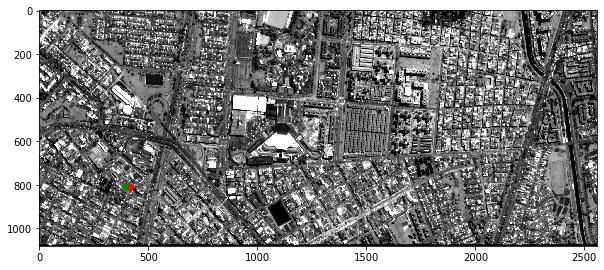

 ----> Real 2D loc in im 7  (sol) =  [533.54150391 816.6182251 ]
 ----> Proj 2D loc in im 7  before BA =  [516.80459061 814.51333344]
 ----> Proj 2D loc in im 7  after  BA =  [533.79494629 816.81078777]
              Reprojection error beofre BA: 18.84180495601288
              Reprojection error after  BA: 0.4460050508147333


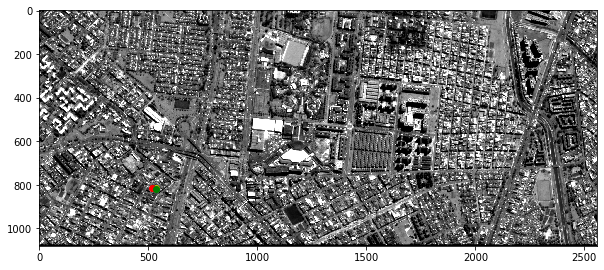

 ----> Real 2D loc in im 8  (sol) =  [520.87164307  81.43102264]
 ----> Proj 2D loc in im 8  before BA =  [510.03971657  77.85056443]
 ----> Proj 2D loc in im 8  after  BA =  [521.28486747  81.37639106]
              Reprojection error beofre BA: 14.41238471015501
              Reprojection error after  BA: 0.46785598528462913


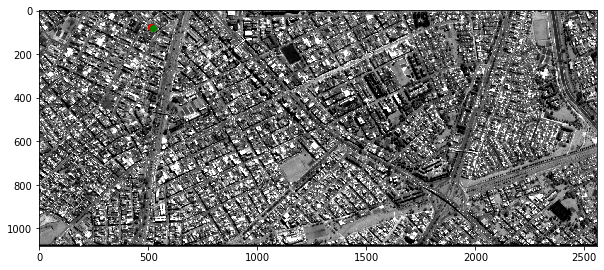

In [10]:
ba_pipeline.visualize_feature_track()

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [24]:
from bundle_adjust.ba_triangulation import project_xyz_bbx_on_map

project_xyz_bbx_on_map(ba_pipeline.pts_3d_ba, map_zoom=14)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [35]:
C = ba_pipeline.C

i, j = 1, 4

visible_idx = np.logical_and(~np.isnan(C[i*2,:]), ~np.isnan(C[j*2,:])) 
pts1, pts2 = C[(i*2):(i*2+2), visible_idx], C[(j*2):(j*2+2), visible_idx]
pts1, pts2 = pts1.T, pts2.T

pts_3d_i_j = ba_pipeline.pts_3d_ba[visible_idx, :]

np.savetxt('../ames_test3/20190617_075138_ssc2d2_0006_basic_panchromatic_dn.matches', pts1)
np.savetxt('../ames_test3/20190617_075212_ssc2d2_0009_basic_panchromatic_dn.matches', pts2)
np.savetxt('../ames_test3/20190617_075138_ssc2d2_0006_basic_panchromatic_dn.points', pts_3d_i_j)

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

image 0, mean abs reproj error before BA: 1.0920
image 0, mean abs reproj error after  BA: 0.1509


<IPython.core.display.Javascript object>


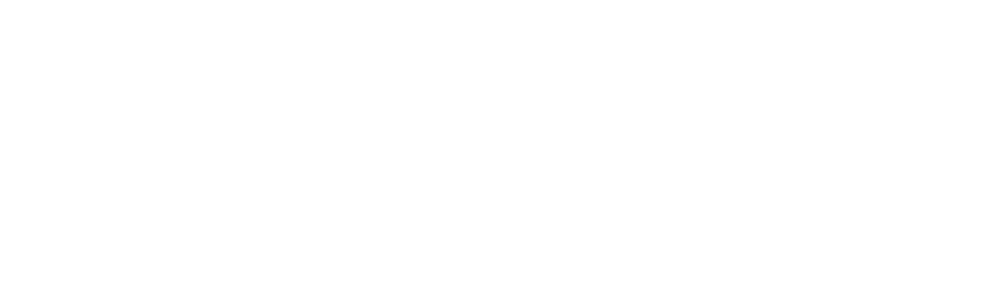

In [44]:
# set the index of the image to analyse
im_idx = 0

ba_pipeline.analyse_reproj_err_particular_image(im_idx)

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [87]:
from bundle_adjust.ba_triangulation import write_feature_tracks_stereo_point_clouds

im_ind = [0, 1, 2, 3, 4, 5]
all_pairs = [(im_i, im_j) for im_i in im_ind for im_j in im_ind if im_i != im_j and im_i<im_j]

#write_feature_tracks_stereo_point_clouds(ba_pipeline.pairs_to_triangulate, ba_pipeline.C, 
#                                         ba_pipeline.input_P, ba_pipeline.P_crop_ba, output_dir=input_dir)

print(all_pairs)
write_feature_tracks_stereo_point_clouds(all_pairs, ba_pipeline.C, 
                                         ba_pipeline.input_P, ba_pipeline.P_crop_ba, output_dir=input_dir, min_pts=0)


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Writing point clouds of SIFT keypoints...
...done!



In [80]:
len(ba_pipeline.pairs_to_match)

13

### Check baseline distances

0 (0,1) 111805.95469514088 True
1 (0,2) 380087.5071564778 False
2 (0,3) 498523.3291369319 False
3 (0,4) 832420.0460054028 False
4 (0,5) 728420.2571013281 False
5 (1,2) 272631.6953025678 False
6 (1,3) 393408.6769643029 False
7 (1,4) 870182.1743394668 False
8 (1,5) 762493.8714354839 False
9 (2,3) 122451.25637560112 True
10 (2,4) 1072660.7789362748 False
11 (2,5) 963026.9622672036 False
12 (3,4) 1184302.6727422813 False
13 (3,5) 1074864.2328021997 False
14 (4,5) 109724.68808353346 True


<IPython.core.display.Javascript object>


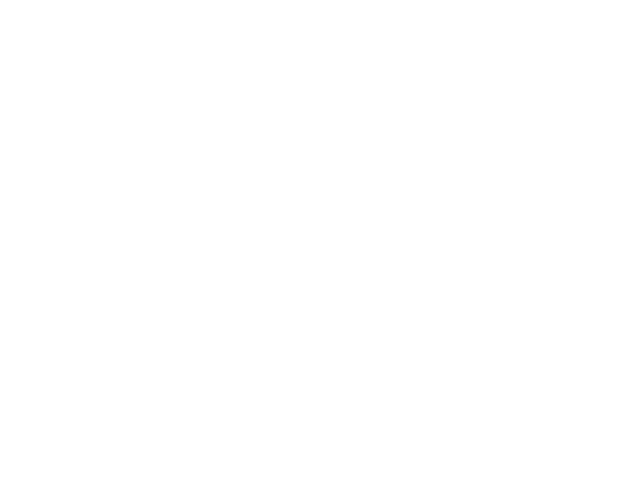

In [81]:
from bundle_adjust import ba_core

baseline_pairs, all_pairs_list = [], []
n_img = len(ba_pipeline.P_crop_ba)
for i in range(n_img):
    for j in range(i+1,n_img):
        
        # check if the baseline between both cameras is large enough
        _, _, _, optical_center1 = ba_core.decompose_perspective_camera(ba_pipeline.P_crop_ba[i])
        _, _, _, optical_center2 = ba_core.decompose_perspective_camera(ba_pipeline.P_crop_ba[j])
        baseline_pairs.append(np.linalg.norm(optical_center2 - optical_center1))
        all_pairs_list.append([i,j])
        
        print(len(all_pairs_list) - 1, '({},{})'.format(i, j), np.linalg.norm(optical_center2 - optical_center1),
             np.linalg.norm(optical_center2 - optical_center1) < 150000)

fig = plt.figure()
plt.plot(baseline_pairs)
plt.show()

In [28]:
baseline_pairs

[111786.71113823685,
 380124.6923568623,
 498550.3948103364,
 832595.0389569288,
 728638.2567844841,
 272665.0363466795,
 393431.19977835944,
 870351.6282104843,
 762698.1042429396,
 122450.76385787281,
 1072708.3165195284,
 963093.298673203,
 1184345.4785507028,
 1074922.8063368616,
 109703.39481444425]

<IPython.core.display.Javascript object>


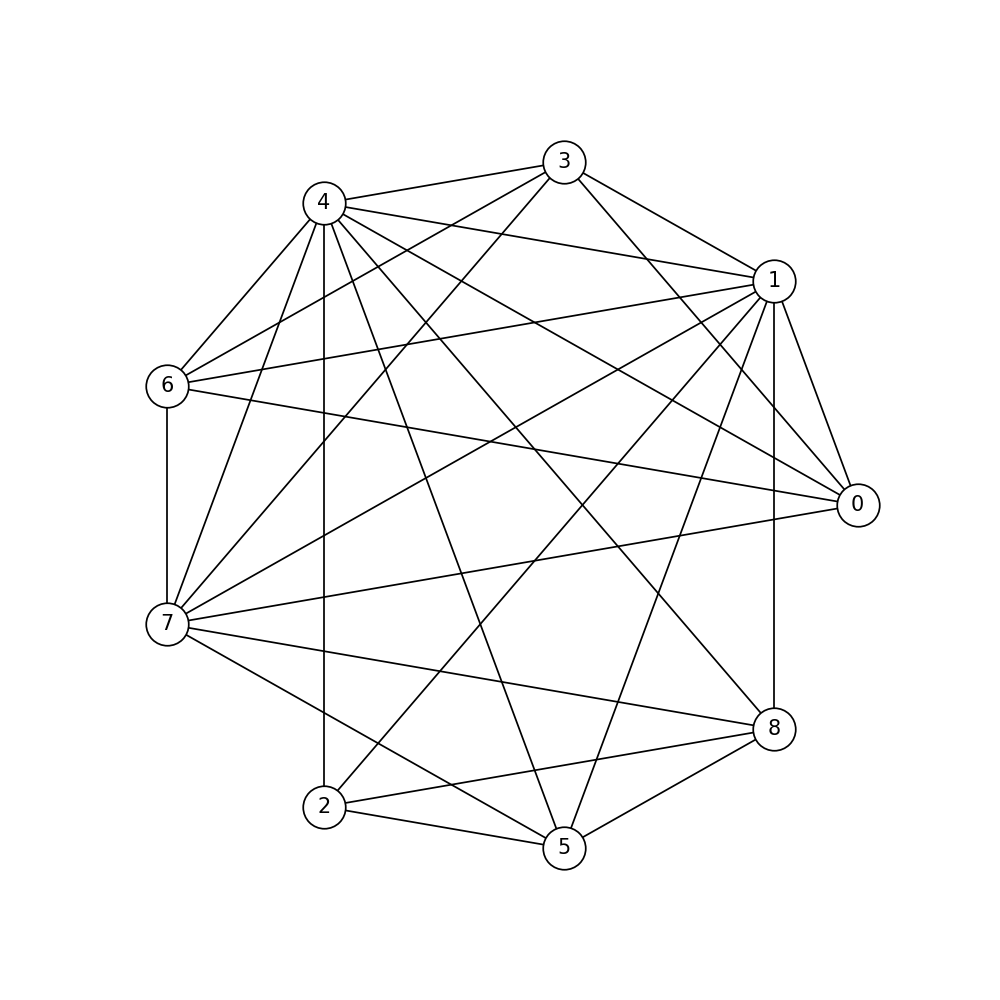

In [23]:
# check connectivity graph

ba_utils.plot_connectivity_graph(ba_pipeline.C, 10, save_pgf=False);

### Compare reprojection error using the L1A projection matrices or rpcs

In [15]:
from bundle_adjust import rpc_fit
import copy

original_rpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]

for im_idx in range(n_cam):

    rpc_init = copy.copy(original_rpcs[im_idx])

    h, w = mycrops[im_idx]['crop'].shape

    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            input_P = np.array(json.load(f)['P_projective'])

    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 0, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts_P, samples = p[idx_to_preserve], samples[idx_to_preserve]

    lat, lon, alt = ba_utils.ecef_to_latlon_custom(samples[:, 0], samples[:, 1], samples[:, 2])

    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)

    rows, cols = original_rpcs[im_idx].projection(lon, lat, alt) # ROWS Y COL ESTAN AL REVES ?
    proj_pts_RPC = np.vstack((rows, cols)).T
    
    print('im {} max diff {}'.format(im_idx, max(np.linalg.norm(proj_pts_P-proj_pts_RPC,axis=1))))

im 0 max diff 1.624686264900918
im 1 max diff 1.295288347219448
im 2 max diff 1.4064774476400503
im 3 max diff 1.3336171271195465
im 4 max diff 1.1450193272163778
im 5 max diff 1.6989949632017207
im 6 max diff 1.709529139507347
im 7 max diff 1.4659059833670325
im 8 max diff 1.1507231546110115


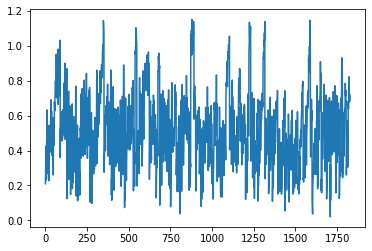

In [16]:
plt.plot(np.linalg.norm(proj_pts_P-proj_pts_RPC, axis=1))

### Plot optical centers in 3D

<IPython.core.display.Javascript object>


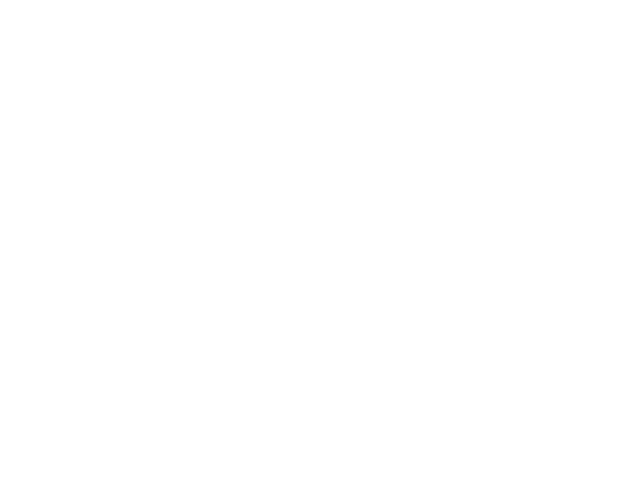

In [21]:
from bundle_adjust import rpc_utils

read_from_matrices = False
read_from_exterior_orientation = False

P_matrices = []
ocenters = []

if read_from_matrices:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            P_matrices.append(np.array(json.load(f)['P_projective']))
            _, _, _, optical_center1 = ba_core.decompose_perspective_camera(P_matrices[-1])
            ocenters.append(optical_center1)    
elif read_from_exterior_orientation:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            tmp = json.load(f)['exterior_orientation']
            x_ecef, y_ecef, z_ecef = tmp['x_ecef_meters'], tmp['y_ecef_meters'], tmp['z_ecef_meters']
            ocenters.append(np.array([x_ecef, y_ecef, z_ecef]))
else: # read from rpcs approximation
    cam_model = 'Perspective'
    P_matrices = []
    for rpc, crop, iter_cont in zip(myrpcs, mycrops, np.arange(len(mycrops))):
        x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
        P_img = rpc_utils.approx_rpc_as_proj_matrix(rpc, [x,x+w,10], [y,y+h,10], \
                                                    [rpc.alt_offset - 100, rpc.alt_offset + 100, 10])
        _, _, _, optical_center1 = ba_core.decompose_perspective_camera(P_img/P_img[2,3])
        ocenters.append(optical_center1)
    
ocenters = np.array(ocenters)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot(ocenters[:,0], ocenters[:,1], ocenters[:,2], 'o')